# Multioutput Gaussian Process test 1, applied to Mocap data-set

Some previous definitions and library invocations needed to process data

In [1]:
%pylab inline
import numpy as np
import pylab as pb
import GPy
import urllib


Populating the interactive namespace from numpy and matplotlib


Fisrt is necesary to retrieve the data from the mocap database located at: http://mocap.cs.cmu.edu/, there one can encounter different datasets of human motion on different situations. There are several files describing the motion of an skeleton, for the purpose of this implementation one can use the .amc files, which specifies the angle of each joint defined by the skeleton for an specific time stamp or frame. The following code retrieves the data of an specific movement previously defined by the user, for that objective first one have to identify the desired motion in this case, a soccer player kicking a ball: http://mocap.cs.cmu.edu/search.php?subjectnumber=10&trinum=6

Then is necesary to copy the link of the amc file located in that page, for this case: mocap.cs.cmu.edu/subjects/10/10_06.amc, then it's only replacing it in the value of the url variable like this:

In [2]:
url = ("http://mocap.cs.cmu.edu/subjects/10/10_06.amc") # Tell to python where is the file
urllib.urlretrieve(url, '10_06.amc') # Tell python to retrieve the file

('10_06.amc', <httplib.HTTPMessage instance at 0x107e19170>)

The file will be downloaded in the same dir where your code or notebook is located, the next code parses the file and extract all the information related with the angles of the joints on each frame, and stores that information in the variable X.

In [84]:
amc_file = open('10_06.amc', 'r')
cont = 0
read_frames = False
print 'Reading header...'
frame = 1
bone = 0
bone_map_dof = {} # Saves the degree of freedom of each joint the key is the signal id
bone_name = {} # saves the id and the name of the joint
all_samples = {} 
bone_map_id = [] # A list of tuples (a,b), a: id of the joint, b: id of the signal corresponding to each joint Dof

samples_frame = 0
for mline in amc_file:
    if(mline == ":DEGREES\r\n" and read_frames == False):
        read_frames = True
        print 'now reading frames'
        continue
    elif(read_frames):
        params = mline.split(' ')
        if params[0] == str(frame) + '\r\n':
            #print 'reading frame: ' + str(frame)
            if(frame >= 2):
                #print samples_frame
                all_samples[frame - 1] = samples_frame

            samples_frame = 0
            frame += 1
            bone = 1
        else:
            if(bone == 1):
                samples_frame = np.array(params[1:len(params)], dtype=float)
                #print samples_frame
                bone_map_dof[bone] = len(params) - 1
                bone_name[bone] = params[0]
                if(frame == 2):
                    for i in range(0,len(params) - 1):
                        tmp_tuple = (bone, i+1)
                        bone_map_id.append(tmp_tuple)
            else:        		
                bone_sample = np.array(params[1:len(params)], dtype=float)
                samples_frame = np.append(samples_frame, bone_sample)
                bone_map_dof[bone] = len(params) - 1
                bone_name[bone] = params[0]
                if(frame == 2):
                    for i in range(0,len(params) - 1):
                        tmp_tuple = (bone, i+1)
                        bone_map_id.append(tmp_tuple)
            bone += 1
            
all_samples[frame - 1] = samples_frame
#print all_samples[1], bone_map, bone_name
X = np.zeros((all_samples[1].shape[0], len(all_samples)))

for i in range(0,len(all_samples)):
    X[:,i] = all_samples[i + 1]
print 'File succesfully loaded'

def GetJoints(djoints, X):
    X_joints = np.zeros((1,X.shape[1]))
    signals_id = []
    #X_joints = np.matrix(X_joints)
    for i in djoints:
        l = 0
        k = 0
        tmp_samples = 0
        for j in bone_map_dof:
            k += bone_map_dof[j]
            if(i == j):
                tmp_samples = X[l:k,:]
                X_joints = np.vstack((X_joints, tmp_samples))
                for w in range(0,bone_map_dof[j]):
                    tmp_tuple = (i, w + 1)
                    signals_id.append(tmp_tuple)
                break       
            l = k
    #print X_joints.shape
    X_joints = X_joints[1:X_joints.shape[0], :]
    #print X_joints.shape
    #print signals_id
    return X_joints, signals_id

def SubSampling(data, samples):    
    ret = np.zeros((data.shape[0], samples))
    #ret = np.matrix(ret)
    if(samples > data.shape[1]/2):
        print 'samples need to be less or equal than half of the real size'
        return ret 
    
    dif = data.shape[1]/samples
    cont = 0
    idx = 0
    while idx < samples:
        #print cont,idx
        ret[:, idx] = data[:, cont]
        cont += dif
        idx += 1
    return ret       


def IsNoisySignal(X,Y):
    d = 1          # input dimension
    var = 10.       # variance
    theta = 50.0 
    k = GPy.kern.RBF(d, variance=var, lengthscale=theta)
    C = k.K(X)
    m = GPy.models.GPRegression(X,Y,k)
    m.optimize()
    var_signal = m.rbf.variance
    #print m
    var_noise = m.Gaussian_noise.variance
    return (np.log(var_signal / var_noise) <= 0.0) # signal to noise ratio

def RemoveNoisySignals(X, input_t, bone_map_id):
    ret_X = X
    ret_bone_map_id = []
    noise_index = np.ones(ret_X.shape[0], dtype=bool)
    for i in range(0, X.shape[0]):
        Y = X[i,:]
        #pb.plot(input_t, X[i,:])
        Y = Y[:,None]
        if IsNoisySignal(input_t, Y):
            print 'removing noisy signal: ', 'bone: ', bone_name[bone_map_id[i][0]], ' DoF number: ', bone_map_id[i][1]
            noise_index[i] = False
            
    ret_X = ret_X[noise_index, :]
    for i in range(X.shape[0]):
        if(noise_index[i]):
            ret_bone_map_id.append(bone_map_id[i])

    return ret_X, ret_bone_map_id
    

#print bone_name
#print bone_map_dof
#print bone_map_id

desired_joints = [8,9,10,12,15,16,17,19]
XX = X
X, bone_map_id = GetJoints(desired_joints, X)
X_sub_sampled = SubSampling(X, 285)
X = X_sub_sampled
time_stamps = np.arange(X.shape[1])
input_t = time_stamps
input_t = input_t[:,None]

for i in desired_joints:
    print i, bone_name[i]

print X.shape, len(bone_map_id)
X,bone_map_id = RemoveNoisySignals(X, input_t, bone_map_id)
print X.shape, len(bone_map_id)
print bone_map_id


Reading header...
now reading frames
File succesfully loaded
8 rclavicle
9 rhumerus
10 rradius
12 rhand
15 lclavicle
16 lhumerus
17 lradius
19 lhand
(16, 285) 16
removing noisy signal:  bone:  rclavicle  DoF number:  1
removing noisy signal:  bone:  rclavicle  DoF number:  2
removing noisy signal:  bone:  lclavicle  DoF number:  1
removing noisy signal:  bone:  lclavicle  DoF number:  2
(12, 285) 12
[(9, 1), (9, 2), (9, 3), (10, 1), (12, 1), (12, 2), (16, 1), (16, 2), (16, 3), (17, 1), (19, 1), (19, 2)]


The variable X is a numpy array like which its rows corresponds to all the time samples of one angle of each joint. The skeleton is defined to give each joint several degrees of freedom depending on the motion constraints, lets check some one of the samples in a graph:

rclavicle


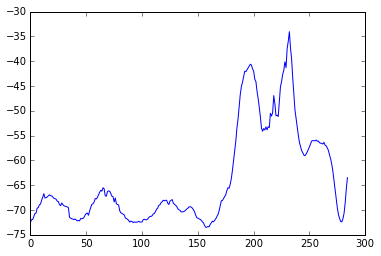

In [87]:
pb.plot(time_stamps, X[2,:])
print bone_name[8]
#print len(bone_map)

## Example of one output GP with some joint signal

<function matplotlib.pyplot.colorbar>

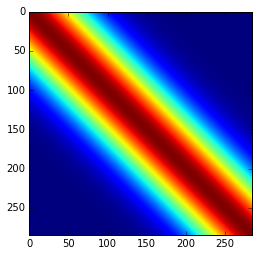

In [22]:
d = 1          # input dimension
var = 10.       # variance
theta = 50.0 
k = GPy.kern.RBF(d, variance=var, lengthscale=theta)
k2 = GPy.kern.Bias(1)
Y = X[0,:]
Y = Y[:, None]
#input_t = np.matrix(time_stamps)
#input_t = np.transpose(input_t)
C = k.K(input_t)
plt.imshow(C)
plt.colorbar
#print time_stamps, input_t

In [88]:
m = GPy.models.GPRegression(input_t,Y,k)
m2 = GPy.models.GPRegression(input_t,Y,k2)

# Multioutput Gaussian Processes

In this section we will try to make multioutput regression using all the outputs of the mocap database , first the covariance matrix will be calculated, then it will be used to make some samples of each for some of the outputs loaded before, some of the points in some of the outputs will be ommited and it will be evaluated the accuracy of the prediction made by the process on those outputs which some of its data points were omitted.

12


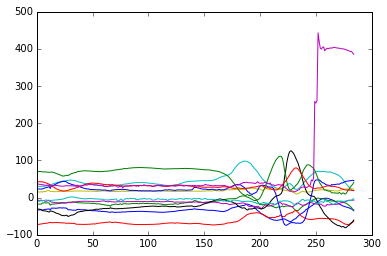

In [89]:
print X.shape[0]
for i in range(0,X.shape[0]):
    # extract the event 
    x_event = time_stamps
    y_event = X[i,:]
    pb.plot(x_event, y_event)
    

The graph above represents all the outputs of the motion of the body for a ceratin sequence. Next it's neccesary to accomodate the input variable(time) as one column vector and the id's of the outputs also in the same way to use the covariance function and the coregionalization matrix respectively.

In [90]:
def SetInputTMOGP(X, input_t, n_signals=5):
    sup_input = input_t[:,0]
    sup_input_id = np.zeros(input_t.shape[0])
    sup_output = X[0,:]
    tmp_output = sup_output
    tmp_input = sup_input
    
    for i in range(1,n_signals):
        tmp_input = np.append(tmp_input, sup_input)
        tmp_input_id = np.linspace(i,i,X.shape[1])
        sup_input_id = np.append(sup_input_id, tmp_input_id)
        tmp_output = np.append(tmp_output, X[i,:])

    sup_input = tmp_input
    #sup_input = sup_input*(1/100.0)
    sup_output = tmp_output
    sup_output = sup_output[:,None]
    all_X = np.vstack((sup_input, sup_input_id))
    all_X = np.transpose(all_X)
    return all_X, sup_output

def ComputeMSQERR(a,b):
    mean_sq_err = a - b
    mean_sq_err = np.power(mean_sq_err, 2)
    val_mean_sq_err = np.sum(mean_sq_err) / mean_sq_err.shape[0]
    return val_mean_sq_err

def ComputeSMSE(F, Y, var):
    mean_sq_err = Y - F
    mean_sq_err = np.power(mean_sq_err, 2)
    all_var = np.sum(var)
    sms_err = mean_sq_err/all_var
    val_smse = np.sum(sms_err)/F.shape[0]
    return val_smse

def ComputeSLL(F, Y, var):
    mean_sq_err = Y - F
    mean_sq_err = np.power(mean_sq_err, 2)
    mean_sq_err = np.divide(mean_sq_err, 2.0*var)
    log_term = 0.5*np.log(var*2.0*np.pi)
    sll = log_term + mean_sq_err
    val_sll = np.sum(sll)/F.shape[0]
    return -1.0*val_sll

def PlottingModel(t,X,model,n_outputs):
    for i in range(n_outputs):
        model.plot(fignum=1,fixed_inputs=[(1, i)], plot_raw=True)

    for i in range(0,n_outputs):
        # extract the event 
        x_event = t
        y_event = X[i,:]
        pb.plot(x_event, y_event)

def GPTest(X, Y, n_signals=5):
    #print Y, X
    # Defining the covariance and the coregionalization matrix, first one can try with an RBF
    print n_signals
    kern1 = GPy.kern.RBF(1., lengthscale=50.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=X.shape[0], rank=n_signals-1)
    kern2 = GPy.kern.RBF(1., lengthscale=50.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=X.shape[0], rank=n_signals-1)
    kern3 = GPy.kern.Matern32(1, variance=2., lengthscale=40.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=X.shape[0], rank=n_signals-1)
    kern = kern1 + kern2 + kern3
    model = GPy.models.GPRegression(X, Y, kern)
    return model

def GPrun(X, t, n_outputs, Ntest=0, optimized=False):
    if(Ntest == 0):
        #print X.shape, time_stamps.shape, input_t.shape
        #n_outputs = X.shape[0]
        #print X.shape, input_t.shape
        X_train, Y_train = SetInputTMOGP(X, t, n_outputs)
        #print X_train, Y_train
        model = GPTest(X_train, Y_train, n_outputs)
        if(optimized):
            model.optimize()
        print X.shape, t.shape
        PlottingModel(t, X, model, n_outputs)
        mu, var = model._raw_predict(X_train)
        print 'Mean Squared Error', ComputeMSQERR(mu,Y_train)
        print 'Standarized Mean Squared Error', ComputeSMSE(mu, Y_train, var)
        print 'Standarized log', ComputeSLL(mu, Y_train, var)
    else:
        n_frames = time_stamps.shape[0]
        index = np.random.permutation(n_frames)

        X_train = index[Ntest:X.shape[1]]
        Y_train = X[:, X_train]
        X_train = X_train[:, None]

        X_test = index[0:Ntest]
        Y_test = X[:, X_test]
        X_test = X_test[:, None]

        print X_train.shape, Y_train.shape
        X_train, Y_train = SetInputTMOGP(Y_train, X_train, n_outputs)
        X_test, Y_test = SetInputTMOGP(Y_test, X_test, n_outputs)

        model = GPTest(X_train, Y_train, n_outputs)
        if(optimized):
            model.optimize()
        PlottingModel(t,X,model,n_outputs)
        mu, var = model._raw_predict(X_test)
        print mu.shape, Y_train.shape, Y_test.shape
        print 'Mean Squared Error', ComputeMSQERR(mu,Y_test)
        print 'Standarized Mean Squared Error', ComputeSMSE(mu, Y_test, var)
        print 'Standarized log', ComputeSLL(mu, Y_test, var)
    
    

## Making 'predictions' with all the dataset

12
(12, 285) (285, 1)
Mean Squared Error 83.9918849219
Standarized Mean Squared Error 0.470529521236
Standarized log -839.062185662


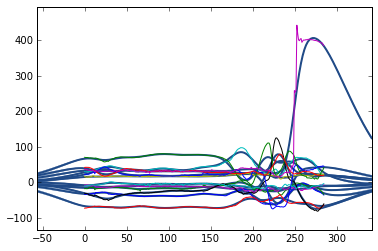

In [91]:
GPrun(X, input_t, X.shape[0]) 

In [ ]:
GPrun(X, input_t, X.shape[0], 0, True) # optimized

## Using test and training Data

(235, 1) (16, 235)
16
(800, 1) (3760, 1) (800, 1)
Mean Squared Error 88.1796725533
Standarized Mean Squared Error 1.79358907563
Standarized log -791.18903179


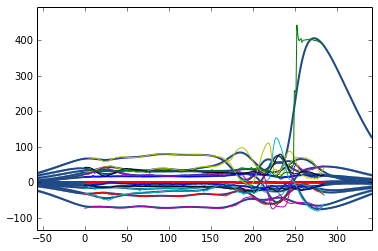

In [21]:
GPrun(X, input_t, X.shape[0], 50)

(235, 1) (16, 235)
16
(800, 1) (3760, 1) (800, 1)
Mean Squared Error 0.536468829124
Standarized Mean Squared Error 0.000221799285242
Standarized log -1.29162251252


 /usr/local/lib/python2.7/dist-packages/GPy/kern/_src/prod.py:47: RuntimeWarning:invalid value encountered in divide


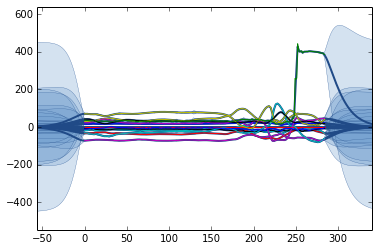

In [22]:
GPrun(X, input_t, X.shape[0], 50, True) # optimized

# Exploting relationship between joints

Exploiting relationship between arms and legs, it's evident that the error is less

In [24]:
print bone_name
desired_joints = [9,10,12,16,17,19,22,13,16,27]
X = GetJoints(desired_joints, XX)
X_sub_sampled = SubSampling(X, 285)
X = X_sub_sampled
time_stamps = np.arange(X.shape[1])
input_t = time_stamps
input_t = input_t[:,None]
print X.shape, input_t.shape

for i in desired_joints:
    print i, bone_name[i]

{1: 'root', 2: 'lowerback', 3: 'upperback', 4: 'thorax', 5: 'lowerneck', 6: 'upperneck', 7: 'head', 8: 'rclavicle', 9: 'rhumerus', 10: 'rradius', 11: 'rwrist', 12: 'rhand', 13: 'rfingers', 14: 'rthumb', 15: 'lclavicle', 16: 'lhumerus', 17: 'lradius', 18: 'lwrist', 19: 'lhand', 20: 'lfingers', 21: 'lthumb', 22: 'rfemur', 23: 'rtibia', 24: 'rfoot', 25: 'rtoes', 26: 'lfemur', 27: 'ltibia', 28: 'lfoot', 29: 'ltoes'}
(20, 285) (285, 1)
9 rhumerus
10 rradius
12 rhand
16 lhumerus
17 lradius
19 lhand
22 rfemur
13 rfingers
16 lhumerus
27 ltibia


20
(20, 285) (285, 1)
Mean Squared Error 72.9780753656
Standarized Mean Squared Error 0.24553552811
Standarized log -746.123596611


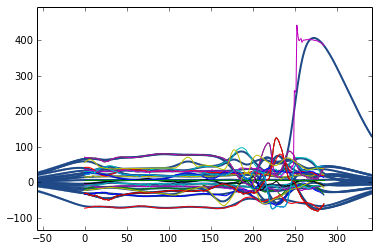

In [25]:
GPrun(X, input_t, X.shape[0]) 

In [ ]:
GPrun(X, input_t, X.shape[0], 0, True) # optimized

Exploting the relationship of one arm

In [27]:
print bone_name
desired_joints = [9,10,12]
X = GetJoints(desired_joints, XX)
X_sub_sampled = SubSampling(X, 285)
X = X_sub_sampled
time_stamps = np.arange(X.shape[1])
input_t = time_stamps
input_t = input_t[:,None]
print X.shape

for i in desired_joints:
    print i, bone_name[i]

{1: 'root', 2: 'lowerback', 3: 'upperback', 4: 'thorax', 5: 'lowerneck', 6: 'upperneck', 7: 'head', 8: 'rclavicle', 9: 'rhumerus', 10: 'rradius', 11: 'rwrist', 12: 'rhand', 13: 'rfingers', 14: 'rthumb', 15: 'lclavicle', 16: 'lhumerus', 17: 'lradius', 18: 'lwrist', 19: 'lhand', 20: 'lfingers', 21: 'lthumb', 22: 'rfemur', 23: 'rtibia', 24: 'rfoot', 25: 'rtoes', 26: 'lfemur', 27: 'ltibia', 28: 'lfoot', 29: 'ltoes'}
(6, 285)
9 rhumerus
10 rradius
12 rhand


6
(6, 285) (285, 1)
Mean Squared Error 7.05812482742
Standarized Mean Squared Error 0.0799415662262
Standarized log -66.7776249047


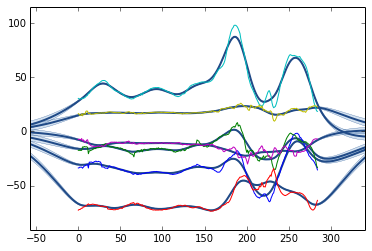

In [28]:
GPrun(X, input_t, X.shape[0]) 

6
(6, 285) (285, 1)
Mean Squared Error 0.0308151690244
Standarized Mean Squared Error 0.000407639918088
Standarized log 0.29150292771


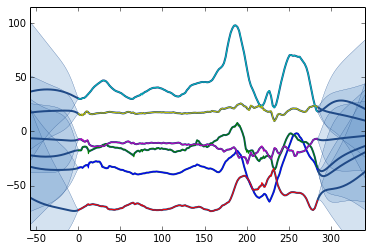

In [29]:
GPrun(X, input_t, X.shape[0], 0, True) # optimized

Degenration using less time steps

In [30]:
print bone_name
desired_joints = [9,10,12]
X = GetJoints(desired_joints, XX)
X_sub_sampled = SubSampling(X, 100)
X = X_sub_sampled
time_stamps = np.arange(X.shape[1])
input_t = time_stamps
input_t = input_t[:,None]
print X.shape, input_t.shape

for i in desired_joints:
    print i, bone_name[i]

{1: 'root', 2: 'lowerback', 3: 'upperback', 4: 'thorax', 5: 'lowerneck', 6: 'upperneck', 7: 'head', 8: 'rclavicle', 9: 'rhumerus', 10: 'rradius', 11: 'rwrist', 12: 'rhand', 13: 'rfingers', 14: 'rthumb', 15: 'lclavicle', 16: 'lhumerus', 17: 'lradius', 18: 'lwrist', 19: 'lhand', 20: 'lfingers', 21: 'lthumb', 22: 'rfemur', 23: 'rtibia', 24: 'rfoot', 25: 'rtoes', 26: 'lfemur', 27: 'ltibia', 28: 'lfoot', 29: 'ltoes'}
(6, 100) (100, 1)
9 rhumerus
10 rradius
12 rhand


6
(6, 100) (100, 1)
Mean Squared Error 34.0771094361
Standarized Mean Squared Error 0.983351866017
Standarized log -289.602123013


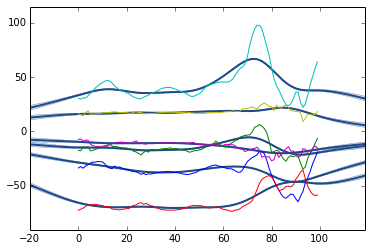

In [31]:
GPrun(X, input_t, X.shape[0]) 

6
(6, 100) (100, 1)
Mean Squared Error 0.189161098801
Standarized Mean Squared Error 0.0012157038798
Standarized log -0.660374223256


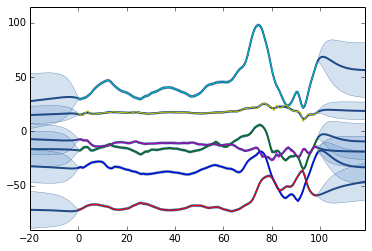

In [32]:
GPrun(X, input_t, X.shape[0], 0, True) # optimized